<a href="https://colab.research.google.com/github/tianyanhong/Colab/blob/main/sim_transfer_cube_human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Run to install MuJoCo and `dm_control`
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

print('Installing dm_control...')
!pip install -q dm_control>=1.0.30

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

Installing dm_control...
env: MUJOCO_GL=egl
Checking that the dm_control installation succeeded...
Installed dm_control 1.0.30


In [2]:
import pathlib #python3中面向对象文件系统的路径操作模块
#机器人操作任务的仿真环境配置系统,
#管理不同任务的数据集路径,机械臂参数和夹爪控制逻辑
### Task parameters
####1.数据集路径
DATA_DIR = '<put your data dir here>'
####2.任务参数
SIM_TASK_CONFIGS = {
    'sim_transfer_cube_scripted':{
        'dataset_dir': DATA_DIR + '/sim_transfer_cube_scripted',
        'num_episodes': 50,
        'episode_len': 400,
        'camera_names': ['top'] #使用的相机列表
    },

    'sim_transfer_cube_human':{
        'dataset_dir': DATA_DIR + '/sim_transfer_cube_human',
        'num_episodes': 50,
        'episode_len': 400,
        'camera_names': ['top']
    },

    'sim_insertion_scripted': {
        'dataset_dir': DATA_DIR + '/sim_insertion_scripted',
        'num_episodes': 50,
        'episode_len': 400,
        'camera_names': ['top']
    },

    'sim_insertion_human': {
        'dataset_dir': DATA_DIR + '/sim_insertion_human',
        'num_episodes': 50,
        'episode_len': 500,
        'camera_names': ['top']
    },
}

### Simulation envs fixed constants
DT = 0.02
JOINT_NAMES = ["waist", "shoulder", "elbow", "forearm_roll", "wrist_angle", "wrist_rotate"]
# 初始关节的位置(16维:左臂8关节 + 右臂8关节)
START_ARM_POSE = [0, -0.96, 1.16, 0, -0.3, 0, 0.02239, -0.02239,  0, -0.96, 1.16, 0, -0.3, 0, 0.02239, -0.02239]

# XML_DIR = str(pathlib.Path(__file__).parent.resolve()) + '/assets/' # note: absolute path

# Left finger position limits (qpos[7]), right_finger = -1 * left_finger
MASTER_GRIPPER_POSITION_OPEN = 0.02417
MASTER_GRIPPER_POSITION_CLOSE = 0.01244
PUPPET_GRIPPER_POSITION_OPEN = 0.05800
PUPPET_GRIPPER_POSITION_CLOSE = 0.01844

# Gripper joint limits (qpos[6])
MASTER_GRIPPER_JOINT_OPEN = 0.3083
MASTER_GRIPPER_JOINT_CLOSE = -0.6842
PUPPET_GRIPPER_JOINT_OPEN = 1.4910
PUPPET_GRIPPER_JOINT_CLOSE = -0.6213

############################ Helper functions ############################

MASTER_GRIPPER_POSITION_NORMALIZE_FN = lambda x: (x - MASTER_GRIPPER_POSITION_CLOSE) / (MASTER_GRIPPER_POSITION_OPEN - MASTER_GRIPPER_POSITION_CLOSE)
PUPPET_GRIPPER_POSITION_NORMALIZE_FN = lambda x: (x - PUPPET_GRIPPER_POSITION_CLOSE) / (PUPPET_GRIPPER_POSITION_OPEN - PUPPET_GRIPPER_POSITION_CLOSE)
MASTER_GRIPPER_POSITION_UNNORMALIZE_FN = lambda x: x * (MASTER_GRIPPER_POSITION_OPEN - MASTER_GRIPPER_POSITION_CLOSE) + MASTER_GRIPPER_POSITION_CLOSE
PUPPET_GRIPPER_POSITION_UNNORMALIZE_FN = lambda x: x * (PUPPET_GRIPPER_POSITION_OPEN - PUPPET_GRIPPER_POSITION_CLOSE) + PUPPET_GRIPPER_POSITION_CLOSE
MASTER2PUPPET_POSITION_FN = lambda x: PUPPET_GRIPPER_POSITION_UNNORMALIZE_FN(MASTER_GRIPPER_POSITION_NORMALIZE_FN(x))

MASTER_GRIPPER_JOINT_NORMALIZE_FN = lambda x: (x - MASTER_GRIPPER_JOINT_CLOSE) / (MASTER_GRIPPER_JOINT_OPEN - MASTER_GRIPPER_JOINT_CLOSE)
PUPPET_GRIPPER_JOINT_NORMALIZE_FN = lambda x: (x - PUPPET_GRIPPER_JOINT_CLOSE) / (PUPPET_GRIPPER_JOINT_OPEN - PUPPET_GRIPPER_JOINT_CLOSE)
MASTER_GRIPPER_JOINT_UNNORMALIZE_FN = lambda x: x * (MASTER_GRIPPER_JOINT_OPEN - MASTER_GRIPPER_JOINT_CLOSE) + MASTER_GRIPPER_JOINT_CLOSE
PUPPET_GRIPPER_JOINT_UNNORMALIZE_FN = lambda x: x * (PUPPET_GRIPPER_JOINT_OPEN - PUPPET_GRIPPER_JOINT_CLOSE) + PUPPET_GRIPPER_JOINT_CLOSE
MASTER2PUPPET_JOINT_FN = lambda x: PUPPET_GRIPPER_JOINT_UNNORMALIZE_FN(MASTER_GRIPPER_JOINT_NORMALIZE_FN(x))

MASTER_GRIPPER_VELOCITY_NORMALIZE_FN = lambda x: x / (MASTER_GRIPPER_POSITION_OPEN - MASTER_GRIPPER_POSITION_CLOSE)
PUPPET_GRIPPER_VELOCITY_NORMALIZE_FN = lambda x: x / (PUPPET_GRIPPER_POSITION_OPEN - PUPPET_GRIPPER_POSITION_CLOSE)

MASTER_POS2JOINT = lambda x: MASTER_GRIPPER_POSITION_NORMALIZE_FN(x) * (MASTER_GRIPPER_JOINT_OPEN - MASTER_GRIPPER_JOINT_CLOSE) + MASTER_GRIPPER_JOINT_CLOSE
MASTER_JOINT2POS = lambda x: MASTER_GRIPPER_POSITION_UNNORMALIZE_FN((x - MASTER_GRIPPER_JOINT_CLOSE) / (MASTER_GRIPPER_JOINT_OPEN - MASTER_GRIPPER_JOINT_CLOSE))
PUPPET_POS2JOINT = lambda x: PUPPET_GRIPPER_POSITION_NORMALIZE_FN(x) * (PUPPET_GRIPPER_JOINT_OPEN - PUPPET_GRIPPER_JOINT_CLOSE) + PUPPET_GRIPPER_JOINT_CLOSE
PUPPET_JOINT2POS = lambda x: PUPPET_GRIPPER_POSITION_UNNORMALIZE_FN((x - PUPPET_GRIPPER_JOINT_CLOSE) / (PUPPET_GRIPPER_JOINT_OPEN - PUPPET_GRIPPER_JOINT_CLOSE))

MASTER_GRIPPER_JOINT_MID = (MASTER_GRIPPER_JOINT_OPEN + MASTER_GRIPPER_JOINT_CLOSE)/2


In [3]:
import numpy as np
import torch
import os
import h5py
from torch.utils.data import TensorDataset, DataLoader

import IPython
e = IPython.embed
#实现了一个用于机器人操作任务（如方块搬运或插孔装配）的 ​​强化学习数据加载和处理管道​​，
class EpisodicDataset(torch.utils.data.Dataset): #加载存储在 HDF5 文件中的 episodic 机器人操作数据
    def __init__(self, episode_ids, dataset_dir, camera_names, norm_stats):
        super(EpisodicDataset).__init__()
        self.episode_ids = episode_ids
        self.dataset_dir = dataset_dir
        self.camera_names = camera_names
        self.norm_stats = norm_stats
        self.is_sim = None
        self.__getitem__(0) # initialize self.is_sim

    def __len__(self):
        return len(self.episode_ids)
    #HDF5文件 → 读取观测/动作 → 标准化 → 转换为PyTorch张量 → 返回批次数据
    def __getitem__(self, index):#从指定 episode 中随机采样一帧或多帧数据,处理观测值（图像、关节位置/速度）和动作数据,自动执行数据标准化（归一化）
        sample_full_episode = False # hardcode

        episode_id = self.episode_ids[index]
        dataset_path = os.path.join(self.dataset_dir, f'episode_{episode_id}.hdf5')
        with h5py.File(dataset_path, 'r') as root:
            is_sim = root.attrs['sim']
            original_action_shape = root['/action'].shape
            episode_len = original_action_shape[0]
            if sample_full_episode:
                start_ts = 0
            else:
                start_ts = np.random.choice(episode_len)
            # get observation at start_ts only
            qpos = root['/observations/qpos'][start_ts]
            qvel = root['/observations/qvel'][start_ts]
            image_dict = dict()
            for cam_name in self.camera_names:
                image_dict[cam_name] = root[f'/observations/images/{cam_name}'][start_ts]
            # get all actions after and including start_ts
            if is_sim:
                action = root['/action'][start_ts:]
                action_len = episode_len - start_ts
            else:
                action = root['/action'][max(0, start_ts - 1):] # hack, to make timesteps more aligned
                action_len = episode_len - max(0, start_ts - 1) # hack, to make timesteps more aligned

        self.is_sim = is_sim
        padded_action = np.zeros(original_action_shape, dtype=np.float32)
        padded_action[:action_len] = action
        is_pad = np.zeros(episode_len)
        is_pad[action_len:] = 1

        # new axis for different cameras
        all_cam_images = []
        for cam_name in self.camera_names:
            all_cam_images.append(image_dict[cam_name])
        all_cam_images = np.stack(all_cam_images, axis=0)

        # construct observations
        image_data = torch.from_numpy(all_cam_images)
        qpos_data = torch.from_numpy(qpos).float()
        action_data = torch.from_numpy(padded_action).float()
        is_pad = torch.from_numpy(is_pad).bool()

        # channel last
        image_data = torch.einsum('k h w c -> k c h w', image_data)

        # normalize image and change dtype to float
        image_data = image_data / 255.0
        action_data = (action_data - self.norm_stats["action_mean"]) / self.norm_stats["action_std"]
        qpos_data = (qpos_data - self.norm_stats["qpos_mean"]) / self.norm_stats["qpos_std"]

        return image_data, qpos_data, action_data, is_pad


def get_norm_stats(dataset_dir, num_episodes):#数据标准化
    all_qpos_data = []
    all_action_data = []
    for episode_idx in range(num_episodes):
        dataset_path = os.path.join(dataset_dir, f'episode_{episode_idx}.hdf5')
        with h5py.File(dataset_path, 'r') as root:
            qpos = root['/observations/qpos'][()]
            qvel = root['/observations/qvel'][()]
            action = root['/action'][()]
        all_qpos_data.append(torch.from_numpy(qpos))
        all_action_data.append(torch.from_numpy(action))
    all_qpos_data = torch.stack(all_qpos_data)
    all_action_data = torch.stack(all_action_data)
    all_action_data = all_action_data

    # normalize action data
    action_mean = all_action_data.mean(dim=[0, 1], keepdim=True)
    action_std = all_action_data.std(dim=[0, 1], keepdim=True)
    action_std = torch.clip(action_std, 1e-2, np.inf) # clipping

    # normalize qpos data
    qpos_mean = all_qpos_data.mean(dim=[0, 1], keepdim=True)
    qpos_std = all_qpos_data.std(dim=[0, 1], keepdim=True)
    qpos_std = torch.clip(qpos_std, 1e-2, np.inf) # clipping

    stats = {"action_mean": action_mean.numpy().squeeze(), "action_std": action_std.numpy().squeeze(),
             "qpos_mean": qpos_mean.numpy().squeeze(), "qpos_std": qpos_std.numpy().squeeze(),
             "example_qpos": qpos}

    return stats


def load_data(dataset_dir, num_episodes, camera_names, batch_size_train, batch_size_val):#数据加载
    print(f'\nData from: {dataset_dir}\n')
    # obtain train test split
    train_ratio = 0.8
    shuffled_indices = np.random.permutation(num_episodes)
    train_indices = shuffled_indices[:int(train_ratio * num_episodes)]
    val_indices = shuffled_indices[int(train_ratio * num_episodes):]

    # obtain normalization stats for qpos and action
    norm_stats = get_norm_stats(dataset_dir, num_episodes)

    # construct dataset and dataloader
    train_dataset = EpisodicDataset(train_indices, dataset_dir, camera_names, norm_stats)
    val_dataset = EpisodicDataset(val_indices, dataset_dir, camera_names, norm_stats)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=True, num_workers=1, prefetch_factor=1)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True, pin_memory=True, num_workers=1, prefetch_factor=1)

    return train_dataloader, val_dataloader, norm_stats, train_dataset.is_sim


### env utils

def sample_box_pose(): #随机生成一个立方体（盒子）的位姿（位置 + 朝向）
    x_range = [0.0, 0.2]
    y_range = [0.4, 0.6]
    z_range = [0.05, 0.05] #限定立方体出现在工作空间的一个矩形区域内

    ranges = np.vstack([x_range, y_range, z_range])#堆叠数据#X2,表示三个纬度的上下界
    cube_position = np.random.uniform(ranges[:, 0], ranges[:, 1]) #生成随机的位置

    cube_quat = np.array([1, 0, 0, 0])
    return np.concatenate([cube_position, cube_quat])

def sample_insertion_pose():
    # Peg 插销
    x_range = [0.1, 0.2]
    y_range = [0.4, 0.6]
    z_range = [0.05, 0.05]

    ranges = np.vstack([x_range, y_range, z_range])#堆叠数据#X2,表示三个纬度的上下界
    peg_position = np.random.uniform(ranges[:, 0], ranges[:, 1]) #生成随机的位置

    peg_quat = np.array([1, 0, 0, 0])
    peg_pose = np.concatenate([peg_position, peg_quat])#拼接 Peg 插销的位姿

    # Socket 孔位
    x_range = [-0.2, -0.1]
    y_range = [0.4, 0.6]
    z_range = [0.05, 0.05]

    ranges = np.vstack([x_range, y_range, z_range])#堆叠数据#X2,表示三个纬度的上下界
    socket_position = np.random.uniform(ranges[:, 0], ranges[:, 1])

    socket_quat = np.array([1, 0, 0, 0])
    socket_pose = np.concatenate([socket_position, socket_quat])#拼接 Socket 插销的位姿

    return peg_pose, socket_pose

### helper functions

def compute_dict_mean(epoch_dicts):
    result = {k: None for k in epoch_dicts[0]}
    num_items = len(epoch_dicts)
    for k in result:
        value_sum = 0
        for epoch_dict in epoch_dicts:
            value_sum += epoch_dict[k]
        result[k] = value_sum / num_items
    return result

def detach_dict(d):
    new_d = dict()
    for k, v in d.items():
        new_d[k] = v.detach()
    return new_d

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)


In [5]:
import numpy as np
import collections
import os

from dm_control import mujoco
from dm_control.rl import control
from dm_control.suite import base

import IPython
e = IPython.embed


def make_ee_sim_env(task_name):
    """
    Environment for simulated robot bi-manual manipulation, with end-effector control.
    Action space:      [left_arm_pose (7),             # position and quaternion for end effector
                        left_gripper_positions (1),    # normalized gripper position (0: close, 1: open)
                        right_arm_pose (7),            # position and quaternion for end effector
                        right_gripper_positions (1),]  # normalized gripper position (0: close, 1: open)

    Observation space: {"qpos": Concat[ left_arm_qpos (6),         # absolute joint position
                                        left_gripper_position (1),  # normalized gripper position (0: close, 1: open)
                                        right_arm_qpos (6),         # absolute joint position
                                        right_gripper_qpos (1)]     # normalized gripper position (0: close, 1: open)
                        "qvel": Concat[ left_arm_qvel (6),         # absolute joint velocity (rad)
                                        left_gripper_velocity (1),  # normalized gripper velocity (pos: opening, neg: closing)
                                        right_arm_qvel (6),         # absolute joint velocity (rad)
                                        right_gripper_qvel (1)]     # normalized gripper velocity (pos: opening, neg: closing)
                        "images": {"main": (480x640x3)}        # h, w, c, dtype='uint8'
    """
    if 'sim_transfer_cube' in task_name: #搬运立方体
        # xml_path = os.path.join(XML_DIR, f'bimanual_viperx_ee_transfer_cube.xml')
        xml_path = "/content/bimanual_viperx_ee_transfer_cube.xml"
        physics = mujoco.Physics.from_xml_path(xml_path)
        task = TransferCubeEETask(random=False)
        env = control.Environment(physics, task, time_limit=20, control_timestep=DT,
                                  n_sub_steps=None, flat_observation=False)
        print(physics.data)
    elif 'sim_insertion' in task_name:
        # xml_path = os.path.join(XML_DIR, f'bimanual_viperx_ee_insertion.xml')
        xml_path = "/content/bimanual_viperx_ee_insertion.xml"
        physics = mujoco.Physics.from_xml_path(xml_path)
        task = InsertionEETask(random=False)
        env = control.Environment(physics, task, time_limit=20, control_timestep=DT,
                                  n_sub_steps=None, flat_observation=False)
        print(physics.data)
    else:
        raise NotImplementedError
    return env

class BimanualViperXEETask(base.Task):
    def __init__(self, random=None):
        super().__init__(random=random)

    def before_step(self, action, physics):
        a_len = len(action) // 2
        action_left = action[:a_len]
        action_right = action[a_len:]

        # set mocap position and quat
        # left
        np.copyto(physics.data.mocap_pos[0], action_left[:3])
        np.copyto(physics.data.mocap_quat[0], action_left[3:7])
        # right
        np.copyto(physics.data.mocap_pos[1], action_right[:3])
        np.copyto(physics.data.mocap_quat[1], action_right[3:7])

        # set gripper
        g_left_ctrl = PUPPET_GRIPPER_POSITION_UNNORMALIZE_FN(action_left[7])
        g_right_ctrl = PUPPET_GRIPPER_POSITION_UNNORMALIZE_FN(action_right[7])
        np.copyto(physics.data.ctrl, np.array([g_left_ctrl, -g_left_ctrl, g_right_ctrl, -g_right_ctrl]))

    def initialize_robots(self, physics):
        # reset joint position
        physics.named.data.qpos[:16] = START_ARM_POSE

        # reset mocap to align with end effector
        # to obtain these numbers:
        # (1) make an ee_sim env and reset to the same start_pose
        # (2) get env._physics.named.data.xpos['vx300s_left/gripper_link']
        #     get env._physics.named.data.xquat['vx300s_left/gripper_link']
        #     repeat the same for right side
        np.copyto(physics.data.mocap_pos[0], [-0.31718881, 0.5, 0.29525084])
        np.copyto(physics.data.mocap_quat[0], [1, 0, 0, 0])
        # right
        np.copyto(physics.data.mocap_pos[1], np.array([0.31718881, 0.49999888, 0.29525084]))
        np.copyto(physics.data.mocap_quat[1],  [1, 0, 0, 0])

        # reset gripper control
        close_gripper_control = np.array([
            PUPPET_GRIPPER_POSITION_CLOSE,
            -PUPPET_GRIPPER_POSITION_CLOSE,
            PUPPET_GRIPPER_POSITION_CLOSE,
            -PUPPET_GRIPPER_POSITION_CLOSE,
        ])
        np.copyto(physics.data.ctrl, close_gripper_control)

    def initialize_episode(self, physics):
        """Sets the state of the environment at the start of each episode."""
        super().initialize_episode(physics)

    @staticmethod
    def get_qpos(physics):
        qpos_raw = physics.data.qpos.copy()
        left_qpos_raw = qpos_raw[:8]
        right_qpos_raw = qpos_raw[8:16]
        left_arm_qpos = left_qpos_raw[:6]
        right_arm_qpos = right_qpos_raw[:6]
        left_gripper_qpos = [PUPPET_GRIPPER_POSITION_NORMALIZE_FN(left_qpos_raw[6])]
        right_gripper_qpos = [PUPPET_GRIPPER_POSITION_NORMALIZE_FN(right_qpos_raw[6])]
        return np.concatenate([left_arm_qpos, left_gripper_qpos, right_arm_qpos, right_gripper_qpos])

    @staticmethod
    def get_qvel(physics):
        qvel_raw = physics.data.qvel.copy()
        left_qvel_raw = qvel_raw[:8]
        right_qvel_raw = qvel_raw[8:16]
        left_arm_qvel = left_qvel_raw[:6]
        right_arm_qvel = right_qvel_raw[:6]
        left_gripper_qvel = [PUPPET_GRIPPER_VELOCITY_NORMALIZE_FN(left_qvel_raw[6])]
        right_gripper_qvel = [PUPPET_GRIPPER_VELOCITY_NORMALIZE_FN(right_qvel_raw[6])]
        return np.concatenate([left_arm_qvel, left_gripper_qvel, right_arm_qvel, right_gripper_qvel])

    @staticmethod
    def get_env_state(physics):
        raise NotImplementedError

    def get_observation(self, physics):
        # note: it is important to do .copy()
        obs = collections.OrderedDict()
        obs['qpos'] = self.get_qpos(physics)
        obs['qvel'] = self.get_qvel(physics)
        obs['env_state'] = self.get_env_state(physics)
        obs['images'] = dict()
        obs['images']['top'] = physics.render(height=480, width=640, camera_id='top')
        obs['images']['angle'] = physics.render(height=480, width=640, camera_id='angle')
        obs['images']['vis'] = physics.render(height=480, width=640, camera_id='front_close')
        # used in scripted policy to obtain starting pose
        obs['mocap_pose_left'] = np.concatenate([physics.data.mocap_pos[0], physics.data.mocap_quat[0]]).copy()
        obs['mocap_pose_right'] = np.concatenate([physics.data.mocap_pos[1], physics.data.mocap_quat[1]]).copy()

        # used when replaying joint trajectory
        obs['gripper_ctrl'] = physics.data.ctrl.copy()
        return obs

    def get_reward(self, physics):
        raise NotImplementedError


class TransferCubeEETask(BimanualViperXEETask):
    def __init__(self, random=None):
        super().__init__(random=random)
        self.max_reward = 4

    def initialize_episode(self, physics):
        """Sets the state of the environment at the start of each episode."""
        self.initialize_robots(physics)
        # randomize box position
        cube_pose = sample_box_pose()
        box_start_idx = physics.model.name2id('red_box_joint', 'joint')
        np.copyto(physics.data.qpos[box_start_idx : box_start_idx + 7], cube_pose)
        # print(f"randomized cube position to {cube_position}")

        super().initialize_episode(physics)

    @staticmethod
    def get_env_state(physics):
        env_state = physics.data.qpos.copy()[16:]
        return env_state

    def get_reward(self, physics):
        # return whether left gripper is holding the box
        all_contact_pairs = []
        for i_contact in range(physics.data.ncon):
            id_geom_1 = physics.data.contact[i_contact].geom1
            id_geom_2 = physics.data.contact[i_contact].geom2
            name_geom_1 = physics.model.id2name(id_geom_1, 'geom')
            name_geom_2 = physics.model.id2name(id_geom_2, 'geom')
            contact_pair = (name_geom_1, name_geom_2)
            all_contact_pairs.append(contact_pair)

        touch_left_gripper = ("red_box", "vx300s_left/10_left_gripper_finger") in all_contact_pairs
        touch_right_gripper = ("red_box", "vx300s_right/10_right_gripper_finger") in all_contact_pairs
        touch_table = ("red_box", "table") in all_contact_pairs

        reward = 0
        if touch_right_gripper:
            reward = 1
        if touch_right_gripper and not touch_table: # lifted
            reward = 2
        if touch_left_gripper: # attempted transfer
            reward = 3
        if touch_left_gripper and not touch_table: # successful transfer
            reward = 4
        return reward


class InsertionEETask(BimanualViperXEETask):
    def __init__(self, random=None):
        super().__init__(random=random)
        self.max_reward = 4

    def initialize_episode(self, physics):
        """Sets the state of the environment at the start of each episode."""
        self.initialize_robots(physics)
        # randomize peg and socket position
        peg_pose, socket_pose = sample_insertion_pose()
        id2index = lambda j_id: 16 + (j_id - 16) * 7 # first 16 is robot qpos, 7 is pose dim # hacky

        peg_start_id = physics.model.name2id('red_peg_joint', 'joint')
        peg_start_idx = id2index(peg_start_id)
        np.copyto(physics.data.qpos[peg_start_idx : peg_start_idx + 7], peg_pose)
        # print(f"randomized cube position to {cube_position}")

        socket_start_id = physics.model.name2id('blue_socket_joint', 'joint')
        socket_start_idx = id2index(socket_start_id)
        np.copyto(physics.data.qpos[socket_start_idx : socket_start_idx + 7], socket_pose)
        # print(f"randomized cube position to {cube_position}")

        super().initialize_episode(physics)

    @staticmethod
    def get_env_state(physics):
        env_state = physics.data.qpos.copy()[16:]
        return env_state

    def get_reward(self, physics):
        # return whether peg touches the pin
        all_contact_pairs = []
        for i_contact in range(physics.data.ncon):
            id_geom_1 = physics.data.contact[i_contact].geom1
            id_geom_2 = physics.data.contact[i_contact].geom2
            name_geom_1 = physics.model.id2name(id_geom_1, 'geom')
            name_geom_2 = physics.model.id2name(id_geom_2, 'geom')
            contact_pair = (name_geom_1, name_geom_2)
            all_contact_pairs.append(contact_pair)

        touch_right_gripper = ("red_peg", "vx300s_right/10_right_gripper_finger") in all_contact_pairs
        touch_left_gripper = ("socket-1", "vx300s_left/10_left_gripper_finger") in all_contact_pairs or \
                             ("socket-2", "vx300s_left/10_left_gripper_finger") in all_contact_pairs or \
                             ("socket-3", "vx300s_left/10_left_gripper_finger") in all_contact_pairs or \
                             ("socket-4", "vx300s_left/10_left_gripper_finger") in all_contact_pairs

        peg_touch_table = ("red_peg", "table") in all_contact_pairs
        socket_touch_table = ("socket-1", "table") in all_contact_pairs or \
                             ("socket-2", "table") in all_contact_pairs or \
                             ("socket-3", "table") in all_contact_pairs or \
                             ("socket-4", "table") in all_contact_pairs
        peg_touch_socket = ("red_peg", "socket-1") in all_contact_pairs or \
                           ("red_peg", "socket-2") in all_contact_pairs or \
                           ("red_peg", "socket-3") in all_contact_pairs or \
                           ("red_peg", "socket-4") in all_contact_pairs
        pin_touched = ("red_peg", "pin") in all_contact_pairs

        reward = 0
        if touch_left_gripper and touch_right_gripper: # touch both
            reward = 1
        if touch_left_gripper and touch_right_gripper and (not peg_touch_table) and (not socket_touch_table): # grasp both
            reward = 2
        if peg_touch_socket and (not peg_touch_table) and (not socket_touch_table): # peg and socket touching
            reward = 3
        if pin_touched: # successful insertion
            reward = 4
        return reward


In [7]:
pip install pyquaternion

[-0.31718881  0.5         0.29525084  1.          0.          0.
  0.          0.          0.31718881  0.49999888  0.29525084  1.
  0.          0.          0.          0.        ]


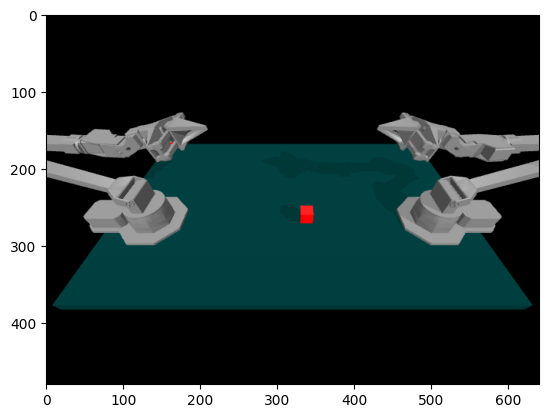

[-0.31501692  0.5         0.29459833  0.99707107  0.00707107  0.
  0.          0.01        0.31416874  0.49980312  0.29341472  0.99851139
  0.         -0.00555556  0.          0.01111111]
[-0.31284503  0.5         0.29394582  0.99414214  0.01414214  0.
  0.          0.02        0.31114868  0.49960735  0.2915786   0.99702279
  0.         -0.01111111  0.          0.02222222]
[-0.31067315  0.5         0.29329331  0.9912132   0.0212132   0.
  0.          0.03        0.30812861  0.49941159  0.28974248  0.99553418
  0.         -0.01666667  0.          0.03333333]
[-0.30850126  0.5         0.29264081  0.98828427  0.02828427  0.
  0.          0.04        0.30510854  0.49921583  0.28790636  0.99404557
  0.         -0.02222222  0.          0.04444444]
[-0.30632937  0.5         0.2919883   0.98535534  0.03535534  0.
  0.          0.05        0.30208847  0.49902007  0.28607024  0.99255697
  0.         -0.02777778  0.          0.05555556]
[-0.30415748  0.5         0.29133579  0.98242641  0.04242641

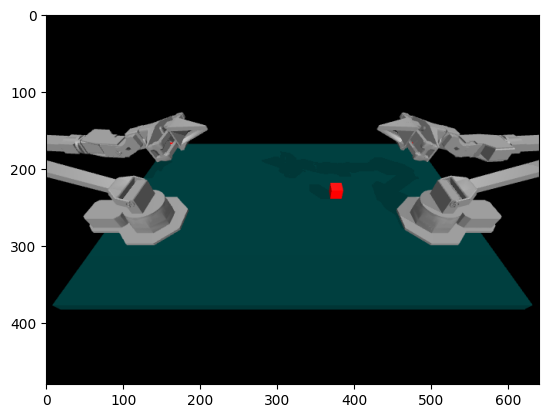

[-0.31501692  0.5         0.29459833  0.99707107  0.00707107  0.
  0.          0.01        0.31537654  0.5010351   0.29341472  0.99851139
  0.         -0.00555556  0.          0.01111111]
[-0.31284503  0.5         0.29394582  0.99414214  0.01414214  0.
  0.          0.02        0.31356428  0.50207132  0.2915786   0.99702279
  0.         -0.01111111  0.          0.02222222]
[-0.31067315  0.5         0.29329331  0.9912132   0.0212132   0.
  0.          0.03        0.31175201  0.50310754  0.28974248  0.99553418
  0.         -0.01666667  0.          0.03333333]
[-0.30850126  0.5         0.29264081  0.98828427  0.02828427  0.
  0.          0.04        0.30993975  0.50414376  0.28790636  0.99404557
  0.         -0.02222222  0.          0.04444444]
[-0.30632937  0.5         0.2919883   0.98535534  0.03535534  0.
  0.          0.05        0.30812748  0.50517998  0.28607024  0.99255697
  0.         -0.02777778  0.          0.05555556]
[-0.30415748  0.5         0.29133579  0.98242641  0.04242641

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

import IPython
e = IPython.embed

#基础策略
class BasePolicy:
    def __init__(self, inject_noise=False):
        self.inject_noise = inject_noise
        self.step_count = 0
        self.left_trajectory = None
        self.right_trajectory = None

    def generate_trajectory(self, ts_first):
        raise NotImplementedError

    @staticmethod
    def interpolate(curr_waypoint, next_waypoint, t):
        t_frac = (t - curr_waypoint["t"]) / (next_waypoint["t"] - curr_waypoint["t"])
        curr_xyz = curr_waypoint['xyz']
        curr_quat = curr_waypoint['quat']
        curr_grip = curr_waypoint['gripper']
        next_xyz = next_waypoint['xyz']
        next_quat = next_waypoint['quat']
        next_grip = next_waypoint['gripper']
        xyz = curr_xyz + (next_xyz - curr_xyz) * t_frac
        quat = curr_quat + (next_quat - curr_quat) * t_frac
        gripper = curr_grip + (next_grip - curr_grip) * t_frac
        return xyz, quat, gripper

    def __call__(self, ts):
        # generate trajectory at first timestep, then open-loop execution
        if self.step_count == 0:
            self.generate_trajectory(ts)

        # obtain left and right waypoints 获取左右航路点
        if self.left_trajectory[0]['t'] == self.step_count:
            self.curr_left_waypoint = self.left_trajectory.pop(0)
        next_left_waypoint = self.left_trajectory[0]

        if self.right_trajectory[0]['t'] == self.step_count:
            self.curr_right_waypoint = self.right_trajectory.pop(0)
        next_right_waypoint = self.right_trajectory[0]

        # interpolate between waypoints to obtain current pose and gripper command 在航路点之间插值以获得当前姿态和抓取器命令
        left_xyz, left_quat, left_gripper = self.interpolate(self.curr_left_waypoint, next_left_waypoint, self.step_count)
        right_xyz, right_quat, right_gripper = self.interpolate(self.curr_right_waypoint, next_right_waypoint, self.step_count)

        # Inject noise
        if self.inject_noise:
            scale = 0.01
            left_xyz = left_xyz + np.random.uniform(-scale, scale, left_xyz.shape)
            right_xyz = right_xyz + np.random.uniform(-scale, scale, right_xyz.shape)

        action_left = np.concatenate([left_xyz, left_quat, [left_gripper]])
        action_right = np.concatenate([right_xyz, right_quat, [right_gripper]])

        self.step_count += 1
        return np.concatenate([action_left, action_right])


class PickAndTransferPolicy(BasePolicy):

    def generate_trajectory(self, ts_first):
        init_mocap_pose_right = ts_first.observation['mocap_pose_right']
        init_mocap_pose_left = ts_first.observation['mocap_pose_left']

        box_info = np.array(ts_first.observation['env_state'])
        box_xyz = box_info[:3]
        box_quat = box_info[3:]
        # print(f"Generate trajectory for {box_xyz=}")

        gripper_pick_quat = Quaternion(init_mocap_pose_right[3:])
        gripper_pick_quat = gripper_pick_quat * Quaternion(axis=[0.0, 1.0, 0.0], degrees=-60)

        meet_left_quat = Quaternion(axis=[1.0, 0.0, 0.0], degrees=90)

        meet_xyz = np.array([0, 0.5, 0.25])

        self.left_trajectory = [
            {"t": 0, "xyz": init_mocap_pose_left[:3], "quat": init_mocap_pose_left[3:], "gripper": 0}, # sleep
            {"t": 100, "xyz": meet_xyz + np.array([-0.1, 0, -0.02]), "quat": meet_left_quat.elements, "gripper": 1}, # approach meet position
            {"t": 260, "xyz": meet_xyz + np.array([0.02, 0, -0.02]), "quat": meet_left_quat.elements, "gripper": 1}, # move to meet position
            {"t": 310, "xyz": meet_xyz + np.array([0.02, 0, -0.02]), "quat": meet_left_quat.elements, "gripper": 0}, # close gripper
            {"t": 360, "xyz": meet_xyz + np.array([-0.1, 0, -0.02]), "quat": np.array([1, 0, 0, 0]), "gripper": 0}, # move left
            {"t": 400, "xyz": meet_xyz + np.array([-0.1, 0, -0.02]), "quat": np.array([1, 0, 0, 0]), "gripper": 0}, # stay
        ]

        self.right_trajectory = [
            {"t": 0, "xyz": init_mocap_pose_right[:3], "quat": init_mocap_pose_right[3:], "gripper": 0}, # sleep
            {"t": 90, "xyz": box_xyz + np.array([0, 0, 0.08]), "quat": gripper_pick_quat.elements, "gripper": 1}, # approach the cube
            {"t": 130, "xyz": box_xyz + np.array([0, 0, -0.015]), "quat": gripper_pick_quat.elements, "gripper": 1}, # go down
            {"t": 170, "xyz": box_xyz + np.array([0, 0, -0.015]), "quat": gripper_pick_quat.elements, "gripper": 0}, # close gripper
            {"t": 200, "xyz": meet_xyz + np.array([0.05, 0, 0]), "quat": gripper_pick_quat.elements, "gripper": 0}, # approach meet position
            {"t": 220, "xyz": meet_xyz, "quat": gripper_pick_quat.elements, "gripper": 0}, # move to meet position
            {"t": 310, "xyz": meet_xyz, "quat": gripper_pick_quat.elements, "gripper": 1}, # open gripper
            {"t": 360, "xyz": meet_xyz + np.array([0.1, 0, 0]), "quat": gripper_pick_quat.elements, "gripper": 1}, # move to right
            {"t": 400, "xyz": meet_xyz + np.array([0.1, 0, 0]), "quat": gripper_pick_quat.elements, "gripper": 1}, # stay
        ]


class InsertionPolicy(BasePolicy):

    def generate_trajectory(self, ts_first):
        init_mocap_pose_right = ts_first.observation['mocap_pose_right']
        init_mocap_pose_left = ts_first.observation['mocap_pose_left']

        peg_info = np.array(ts_first.observation['env_state'])[:7]
        peg_xyz = peg_info[:3]
        peg_quat = peg_info[3:]

        socket_info = np.array(ts_first.observation['env_state'])[7:]
        socket_xyz = socket_info[:3]
        socket_quat = socket_info[3:]

        gripper_pick_quat_right = Quaternion(init_mocap_pose_right[3:])
        gripper_pick_quat_right = gripper_pick_quat_right * Quaternion(axis=[0.0, 1.0, 0.0], degrees=-60)

        gripper_pick_quat_left = Quaternion(init_mocap_pose_right[3:])
        gripper_pick_quat_left = gripper_pick_quat_left * Quaternion(axis=[0.0, 1.0, 0.0], degrees=60)

        meet_xyz = np.array([0, 0.5, 0.15])
        lift_right = 0.00715

        self.left_trajectory = [
            {"t": 0, "xyz": init_mocap_pose_left[:3], "quat": init_mocap_pose_left[3:], "gripper": 0}, # sleep
            {"t": 120, "xyz": socket_xyz + np.array([0, 0, 0.08]), "quat": gripper_pick_quat_left.elements, "gripper": 1}, # approach the cube
            {"t": 170, "xyz": socket_xyz + np.array([0, 0, -0.03]), "quat": gripper_pick_quat_left.elements, "gripper": 1}, # go down
            {"t": 220, "xyz": socket_xyz + np.array([0, 0, -0.03]), "quat": gripper_pick_quat_left.elements, "gripper": 0}, # close gripper
            {"t": 285, "xyz": meet_xyz + np.array([-0.1, 0, 0]), "quat": gripper_pick_quat_left.elements, "gripper": 0}, # approach meet position
            {"t": 340, "xyz": meet_xyz + np.array([-0.05, 0, 0]), "quat": gripper_pick_quat_left.elements,"gripper": 0},  # insertion
            {"t": 400, "xyz": meet_xyz + np.array([-0.05, 0, 0]), "quat": gripper_pick_quat_left.elements, "gripper": 0},  # insertion
        ]

        self.right_trajectory = [
            {"t": 0, "xyz": init_mocap_pose_right[:3], "quat": init_mocap_pose_right[3:], "gripper": 0}, # sleep
            {"t": 120, "xyz": peg_xyz + np.array([0, 0, 0.08]), "quat": gripper_pick_quat_right.elements, "gripper": 1}, # approach the cube
            {"t": 170, "xyz": peg_xyz + np.array([0, 0, -0.03]), "quat": gripper_pick_quat_right.elements, "gripper": 1}, # go down
            {"t": 220, "xyz": peg_xyz + np.array([0, 0, -0.03]), "quat": gripper_pick_quat_right.elements, "gripper": 0}, # close gripper
            {"t": 285, "xyz": meet_xyz + np.array([0.1, 0, lift_right]), "quat": gripper_pick_quat_right.elements, "gripper": 0}, # approach meet position
            {"t": 340, "xyz": meet_xyz + np.array([0.05, 0, lift_right]), "quat": gripper_pick_quat_right.elements, "gripper": 0},  # insertion
            {"t": 400, "xyz": meet_xyz + np.array([0.05, 0, lift_right]), "quat": gripper_pick_quat_right.elements, "gripper": 0},  # insertion

        ]


def test_policy(task_name):
    # example rolling out pick_and_transfer policy
    onscreen_render = True
    inject_noise = False

    # setup the environment
    episode_len = SIM_TASK_CONFIGS[task_name]['episode_len']
    if 'sim_transfer_cube' in task_name:
        env = make_ee_sim_env('sim_transfer_cube')
    elif 'sim_insertion' in task_name:
        env = make_ee_sim_env('sim_insertion')
    else:
        raise NotImplementedError

    for episode_idx in range(2):
        ts = env.reset()
        episode = [ts]
        if onscreen_render:
            ax = plt.subplot()
            plt_img = ax.imshow(ts.observation['images']['angle'])
            plt.ion()

        policy = PickAndTransferPolicy(inject_noise)
        for step in range(episode_len):
            action = policy(ts)
            print(action)
            ts = env.step(action)
            episode.append(ts)
            if onscreen_render:
                plt_img.set_data(ts.observation['images']['angle'])
                plt.pause(0.02)
        plt.close()

        episode_return = np.sum([ts.reward for ts in episode[1:]])
        if episode_return > 0:
            print(f"{episode_idx=} Successful, {episode_return=}")
        else:
            print(f"{episode_idx=} Failed")


if __name__ == '__main__':
    test_task_name = 'sim_transfer_cube_scripted'
    test_policy(test_task_name)

